In [11]:
import mphot
import numpy as np
import matplotlib.pyplot as plt

## Single PWV effect evaluation


In [12]:
instrument_efficiency_path = "../resources/systems/speculoos_PIRT_1280SciCam_-60.csv"  # index in microns, efficiency of telescope+instrument as fraction
filter_path = (
    "../resources/filters/zYJ.csv"  # index in microns, filter efficiency as fraction
)

name, system_response = mphot.generate_system_response(
    instrument_efficiency_path, filter_path
)

INFO:mphot.core:`/Users/peter/Github/mphot/src/mphot/datafiles/system_responses/speculoos_PIRT_1280SciCam_-60_zYJ_instrument_system_response.csv` has been generated and saved!


<Axes: title={'center': 'speculoos_PIRT_1280SciCam_-60_zYJ'}, xlabel='Wavelength (microns)', ylabel='System Response'>

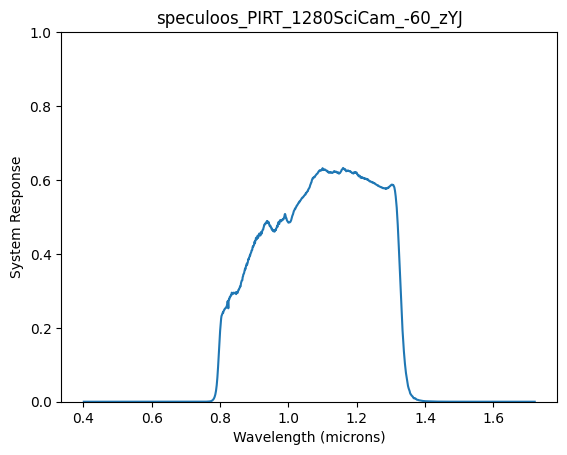

In [13]:
system_response.plot(
    xlabel="Wavelength (microns)", ylabel="System Response", title=name, ylim=(0, 1)
)

In [14]:
pwvs = np.arange(0.05, 20, 0.5)  # [mm]
teffs = np.arange(2000, 6500, 500)  # [K]

# sky properties
props_sky = {
    "pwv": 2.5,  # PWV [mm]
    "airmass": 1.1,  # airmass
    "seeing": 1.35,  # seeing (==FWHM) ["]
}

# instrument properties
props_instrument = {
    "name": name,  # name to get SR/precision grid from file
    "plate_scale": 0.31,  # pixel plate scale ["]
    "N_dc": 110,  # dark current [e/pix/s]
    "N_rn": 90,  # read noise [e_rms/pix]
    "well_depth": 56000,  # well depth [e/pix]
    "well_fill": 0.7,  # fractional value to fill central target pixel, assuming gaussian (width function of seeing^)
    "read_time": 0.1,  # read time between images [s]
    "r0": 0.5,  # radius of telescope's primary mirror [m]
    "r1": 0.14,  # radius of telescope's secondary mirror [m]
    # "min_exp" : 0,          # optional, minimum exposure time [s]
    # "max_exp" : 120,        # optional, maximum exposure time [s]
    # "ap_rad" : 3            # optional, aperture radius [FWHM, seeing] for photometry -- 3 default == 7 sigma of Gaussian
}

# target properties
# Teff = 2566  # [K]
distance = 12.5  # [pc]

In [15]:
fluxes = {}
for Teff in teffs:
    fluxes[Teff] = {}
    for pwv in pwvs:
        props_sky["pwv"] = pwv
        props_instrument["name"] = name
        image_precision, binned_precision, components = mphot.get_precision(
            props_instrument,
            props_sky,
            Teff,
            distance,
        )
        fluxes[Teff][pwv] = components["N_star [e/s]"]

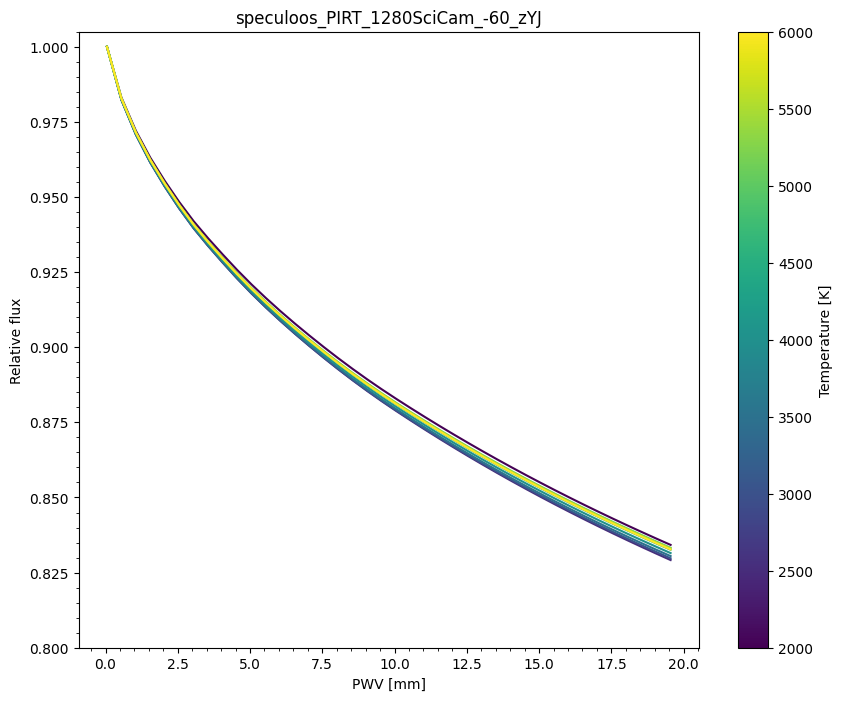

In [16]:
# plot relative flux vs PWV for each Teff, where relative flux is flux / flux_0, where flux_0 is the flux at 0.05 mm per Teff
fig, ax = plt.subplots(figsize=(10, 8))
norm = plt.Normalize(vmin=teffs.min(), vmax=teffs.max())
cmap = plt.cm.viridis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for Teff in teffs:
    ax.plot(
        pwvs,
        [fluxes[Teff][pwv] / fluxes[Teff][0.05] for pwv in pwvs],
        label=f"{Teff} K",
        color=cmap(norm(Teff)),
    )

ax.set_ylim(0.8, 1.005)
ax.set_xlabel("PWV [mm]")
ax.set_ylabel("Relative flux")
ax.set_title(f"{name}")
ax.minorticks_on()
fig.colorbar(sm, ax=ax, label="Temperature [K]")

In [17]:
Teff_high_delta_flux = fluxes[teffs[-1]][pwvs[-1]] / fluxes[teffs[-1]][0.05]
Teff_low_delta_flux = fluxes[teffs[0]][pwvs[-1]] / fluxes[teffs[0]][0.05]
print(
    f"Teff high delta flux: {Teff_high_delta_flux}"
    f"\nTeff low delta flux: {Teff_low_delta_flux}"
)
# print(1 - Teff_low_delta_flux)
# The diff metric quantifies the difference in relative flux change between the highest and lowest Teff (stellar effective temperature) as PWV (precipitable water vapor) increases from its minimum to maximum value.
# Specifically, it measures how much more the relative flux drops for the hottest star compared to the coolest star, scaled by the fractional flux loss of the coolest star.
# This helps assess how sensitive stars of different temperatures are to atmospheric water vapor absorption in the observed band.

diff = (Teff_high_delta_flux - Teff_low_delta_flux) * (1 - Teff_low_delta_flux)
print(diff)

Teff high delta flux: 0.8327028315649967
Teff low delta flux: 0.8342208151586263
-0.00025165008275450173
